Загружаем необходимые библиотеки

In [1]:
%pylab inline
import numpy as np
import warnings

from scipy import sparse

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

Выключаем предупреждения вида 
```
UserWarning: Label not 83 is present in all training examples.
```
Такие сообщения возникают, если в данных не представлен какой-либо класс. Это будет происходит при кросс-валидации.

## Подготовка данных

Напишем функцию для считывания данных в разреженную матрицу.

In [3]:
def read_data_from_file(filename, shape):
    values = list()
    rows = list()
    cols = list()
    
    header = True
    for line in open(filename):
        if header:
            header = False
            continue
        row, col, value = [x for x in line.strip().split(',')]
        row, col = int(row), int(col)
        value = float(value)
        row -= 1
        col -= 1
        values.append(value)
        rows.append(row)
        cols.append(col)
        
    return sparse.csr_matrix((values, (rows, cols)), shape=shape)

Считаем данные

In [4]:
X_train = read_data_from_file('X_train.csv', (15000, 30000)).astype(float)
X_test = read_data_from_file('X_test.csv', (15000, 30000)).astype(float)
X_train.shape, X_test.shape

((15000, 30000), (15000, 30000))

Нормируем признаки

In [5]:
X_all = sparse.vstack([X_train, X_test])
X_all = scale(X_all, with_mean=False)
X_train = X_all[:15000, :]
X_test = X_all[15000:, :]

del X_all

Напишем функцию для считывания меток

In [6]:
def read_labels_from_file(filename, shape):
    labels = np.zeros(shape).astype(int)

    header = True
    for line in open(filename):
        if header:
            header = False
            continue
        row, indeces = line.strip().split(',')
        row = int(row) - 1
        indeces = [int(x) - 1 for x in indeces.split()]
        labels[row, indeces] = 1
    
    return labels

Считаем истинные метки

In [7]:
y_train = read_labels_from_file('y_train.csv', (15000, 98))
y_train.shape

(15000, 98)

И, наконец, напишем функция для вывода меток в нужном формате

In [8]:
def write_labels_to_file(labels, filename):
    lines = ['Id,Labels']
    for i, line in enumerate(labels):
        elements = [str(x) for x in list(nonzero(line)[0] + 1)]
        lines.append('%d,%s' % (i + 1, ' '.join(elements)))
    with open(filename, 'w') as outfile:
        outfile.write('\n'.join(lines))

Напишем вспомогательную функцию для визуализации результатов

In [9]:
def plot_grid_searcher_results(grid_seacher, log_scale):
    means = list()
    param_values = list()

    for score in grid_searcher.grid_scores_:
        print(score.cv_validation_scores)
        means.append(score.mean_validation_score)
        param_values.append(list(score.parameters.values())[0])

    parameter_name = list(grid_searcher.grid_scores_[0].parameters.keys())[0]
    means = np.array(means)
    
    plot(param_values, means)
    if log_scale:
        xscale('log')
    xlabel(parameter_name)
    ylabel('Quality')

Визуализируем качество работы алгоритма в зависимости от числа соседей

## Logistic Regression

Оценим качество в зависимости от параметра регуляризации

In [10]:
params = {'estimator__C': np.logspace(-2, 2, 5)},
clf = OneVsRestClassifier(LogisticRegression())
grid_searcher = GridSearchCV(clf, params, scoring=make_scorer(f1_score, average='samples'), cv=5, verbose=10, n_jobs=-1)
grid_searcher.fit(X_train, y_train)
grid_searcher.best_score_, grid_searcher.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  4.2min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  5.6min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  7.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  7.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.3min finished


(0.33848920634920637,
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
           n_jobs=1))

Визуализируем зависимость качества от регуляризации

[ 0.28618889  0.31459524  0.32359524  0.33862381  0.28971905]
[ 0.30771111  0.34277302  0.34229524  0.3586254   0.3067746 ]
[ 0.30994444  0.35090794  0.34671746  0.36749048  0.31738571]
[ 0.30716667  0.35244127  0.34041746  0.36165873  0.32419286]
[ 0.30988201  0.34983889  0.33887407  0.35976508  0.32335397]


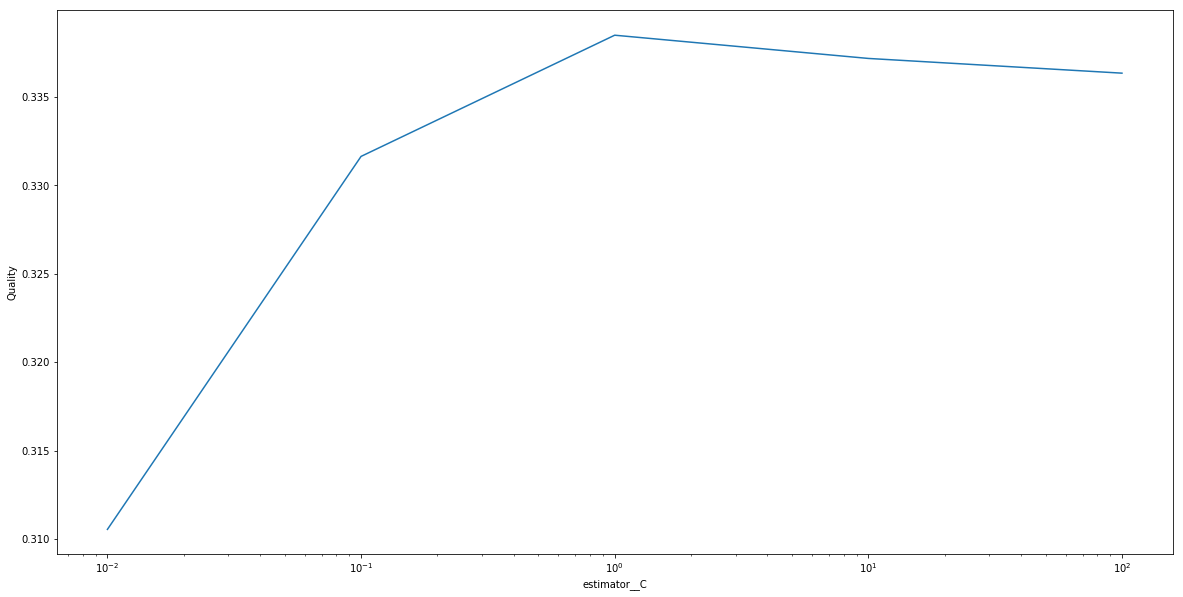

In [11]:
plot_grid_searcher_results(grid_searcher, log_scale=True)

Видно, что оптимальным параметром будет единица. Рассмотрим поближе ее окрестность:

In [12]:
params = {'estimator__C': np.linspace(0.8, 1.2, 20)},
clf = OneVsRestClassifier(LogisticRegression())
grid_searcher = GridSearchCV(clf, params, scoring=make_scorer(f1_score, average='samples'), cv=5, verbose=10, n_jobs=-1)
grid_searcher.fit(X_train, y_train)
grid_searcher.best_score_, grid_searcher.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 33.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 34.6min finished


(0.33910253968253973,
 OneVsRestClassifier(estimator=LogisticRegression(C=0.82105263157894737, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
           n_jobs=1))

[ 0.31088889  0.35218571  0.34688413  0.36617937  0.31806349]
[ 0.31122222  0.35196349  0.34743968  0.36682381  0.31806349]
[ 0.31055556  0.35185238  0.34760635  0.36665714  0.31728571]
[ 0.31011111  0.35185238  0.34705079  0.36684603  0.31745238]
[ 0.31016667  0.35196349  0.3471619   0.36743492  0.31778571]
[ 0.31072222  0.35129683  0.34705079  0.36754603  0.31834127]
[ 0.30961111  0.35118571  0.34693968  0.36710159  0.31784127]
[ 0.30983333  0.35040794  0.34710635  0.36765714  0.31786349]
[ 0.30983333  0.35040794  0.3471619   0.36782381  0.31789683]
[ 0.31005556  0.35118571  0.34693968  0.36754603  0.31771905]
[ 0.31027778  0.35074127  0.34643968  0.36747937  0.3172746 ]
[ 0.31027778  0.35135238  0.34721746  0.36725714  0.31749683]
[ 0.31027778  0.35101905  0.34723968  0.36759048  0.31760794]
[ 0.31027778  0.35146349  0.34705079  0.36759048  0.31738571]
[ 0.31016667  0.35096349  0.34723968  0.36750317  0.31783016]
[ 0.3105      0.35129683  0.34685079  0.36761429  0.31760794]
[ 0.3101

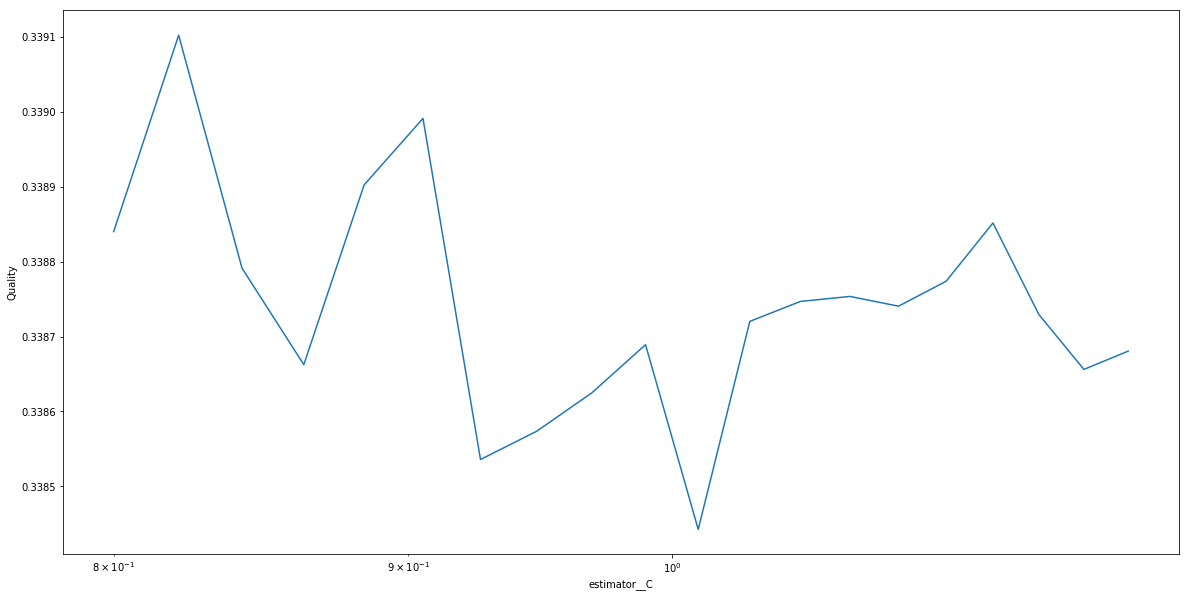

In [13]:
plot_grid_searcher_results(grid_searcher, log_scale=True)

Попробуем другой классификатор:

In [14]:
params = {'estimator__C': np.logspace(-2.5, -1.5, 10)},
clf = OneVsRestClassifier(LinearSVC())
grid_searcher = GridSearchCV(clf, params, scoring=make_scorer(f1_score, average='samples'), cv=5, verbose=10, n_jobs=-1)
grid_searcher.fit(X_train, y_train)
grid_searcher.best_score_, grid_searcher.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  2.3min remaining:   30.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  2.5min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


(0.34510206349206346,
 OneVsRestClassifier(estimator=LinearSVC(C=0.0087992254356910743, class_weight=None, dual=True,
      fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
      max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
      tol=0.0001, verbose=0),
           n_jobs=1))

[ 0.31755079  0.35224444  0.35305794  0.36805317  0.32417143]
[ 0.31710635  0.35448889  0.34985873  0.36910397  0.32256508]
[ 0.31643651  0.35418889  0.35033651  0.37094206  0.32333175]
[ 0.31576984  0.3556      0.35195079  0.37199762  0.32599683]
[ 0.31710952  0.353       0.35312857  0.37253095  0.32974127]
[ 0.31700952  0.35151111  0.35333968  0.37271984  0.32960794]
[ 0.3167873   0.35117778  0.35223889  0.37038492  0.32910794]
[ 0.31439841  0.35239524  0.35358333  0.36873492  0.32704127]
[ 0.31383175  0.35388333  0.34995     0.36917937  0.32705079]
[ 0.31387619  0.35315635  0.34913889  0.36547937  0.32675   ]


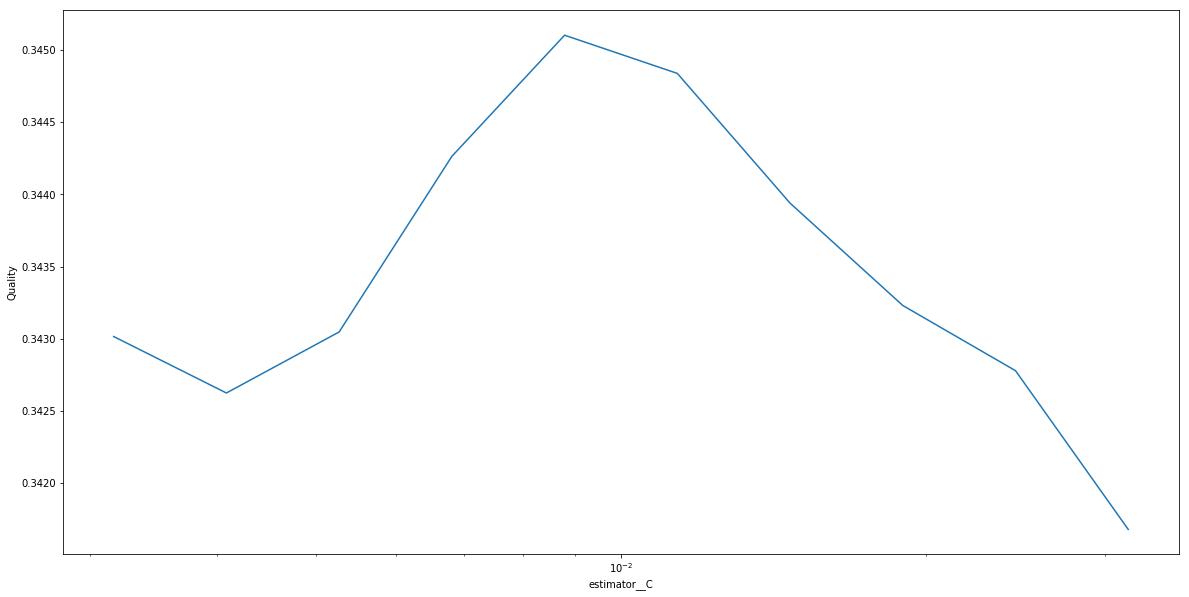

In [15]:
plot_grid_searcher_results(grid_searcher, log_scale=True)

Видно, что результат не стал лучше. Следующим шагом стала попытка поменять шаг предобработки данных. Так как для логистической регрессии не важно масштабирование, сначала я решил его убрать и посмотреть, каким будет качество на исходных данных.

In [16]:
X_train = read_data_from_file('X_train.csv', (15000, 30000)).astype(float)
X_test = read_data_from_file('X_test.csv', (15000, 30000)).astype(float)

In [17]:
params = {'estimator__C': np.linspace(150, 180, 20)},
clf = OneVsRestClassifier(LogisticRegression(penalty='l1', random_state=42))
grid_searcher = GridSearchCV(clf, params, scoring=make_scorer(f1_score, average='samples'), cv=5, verbose=10, n_jobs=-1)
grid_searcher.fit(X_train, y_train)
grid_searcher.best_score_, grid_searcher.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.5min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished


(0.42494613756613764,
 OneVsRestClassifier(estimator=LogisticRegression(C=153.15789473684211, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
           n_jobs=1))

[ 0.41348254  0.44371005  0.42308413  0.44254444  0.40132063]
[ 0.41359365  0.44396561  0.42313968  0.44232222  0.40109841]
[ 0.41392698  0.44424339  0.42297302  0.44293333  0.40065397]
[ 0.41370476  0.4443545   0.4233619   0.44204444  0.39937619]
[ 0.4140381   0.44337672  0.42280635  0.44194444  0.39964286]
[ 0.41361587  0.44409894  0.42277302  0.44084444  0.40019841]
[ 0.41361587  0.44421005  0.42271746  0.44128889  0.40053175]
[ 0.41386984  0.4438545   0.42299524  0.44051111  0.40047619]
[ 0.41331429  0.44437672  0.42277302  0.44095556  0.4005873 ]
[ 0.41364762  0.4443545   0.42238413  0.44162222  0.40036508]
[ 0.41375873  0.44482116  0.42205079  0.4409      0.40036508]
[ 0.4137254   0.44463228  0.42305079  0.44095556  0.40019841]
[ 0.41389206  0.44432116  0.42305079  0.44051111  0.40019841]
[ 0.41389206  0.4448545   0.42271746  0.44084444  0.40025397]
[ 0.41424762  0.44409894  0.42232857  0.44095556  0.40005397]
[ 0.41335873  0.44456085  0.4231619   0.44106667  0.3998873 ]
[ 0.4138

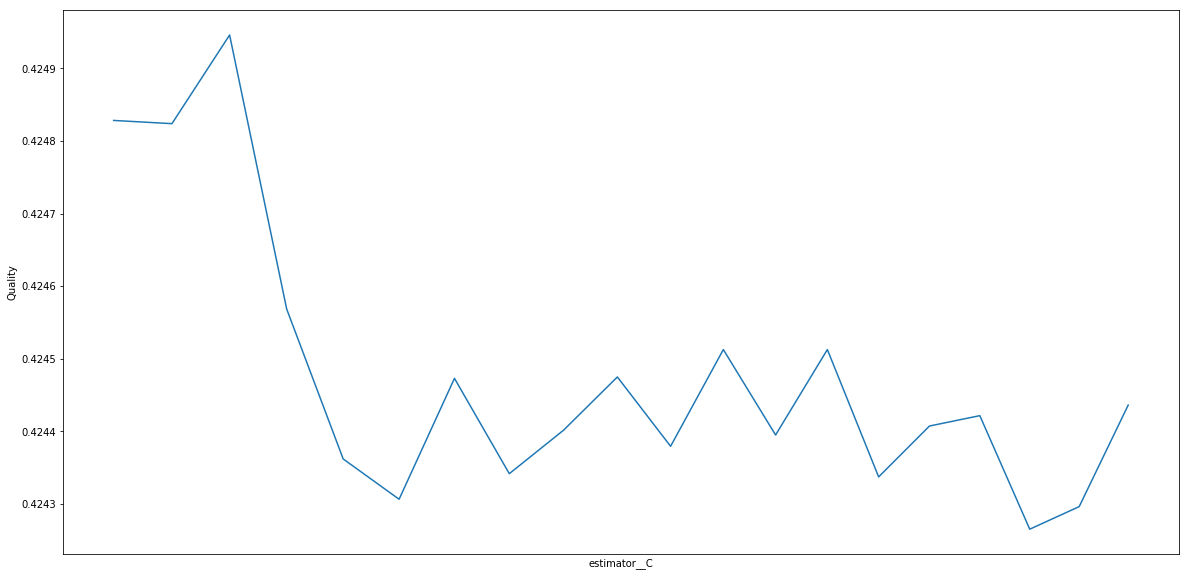

In [18]:
plot_grid_searcher_results(grid_searcher, log_scale=True)

In [19]:
clf = OneVsRestClassifier(LogisticRegression(C=153.15789473684211, penalty='l1', random_state=42))
clf.fit(X_train, y_train)
y_test_lr = clf.predict(X_test)
write_labels_to_file(y_test_lr, 'y_test_lr.csv')

На удивление, результат значительно улучшился.